## 针对分类模型（ResNet18）的基于梯度的对抗攻击

### 1、读取Cifar10图像

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# 2. 加载 CIFAR-10 数据集，使用test集
testset = torchvision.datasets.CIFAR10(root='./dataset', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=13)

# 3. 获取一批图像和标签
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

Files already downloaded and verified


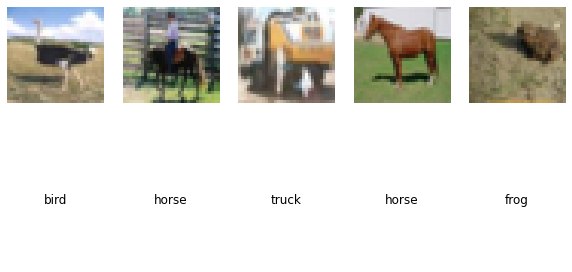

In [2]:
import matplotlib.pyplot as plt
from utils.utils import denorm

# 定义 CIFAR-10 类别
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 绘制图像并显示标签
fig, axes = plt.subplots(2, 5, figsize=(10, 5))


# 第一行：显示5张图像
for i in range(5):
    axes[0, i].imshow(denorm(images)[i].cpu().numpy().transpose((1, 2, 0)))
    axes[0, i].axis('off')

# 第二行：显示标签
for i in range(5):
    axes[1, i].text(0.5, 0.5, classes[labels[i]], fontsize=12, ha='center')
    axes[1, i].axis('off')

plt.show()

### 2、用cifar10对原始图像进行分类

In [3]:
import torch.nn as nn
from tarmodel.ResNet import ResNet18

n_class = 10
model = ResNet18() # 得到预训练模型
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = torch.nn.Linear(512, n_class) # 将最后的全连接层修改
# 载入权重
model.load_state_dict(torch.load('checkpoints/resnet18_cifar10.pt'))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

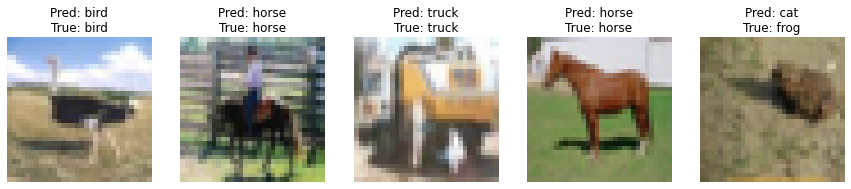

In [4]:
# CIFAR-10 类别
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 1. 获取预测结果
output = model(images.to(device))  # 假设 images 是你的输入图像
_, pred = torch.max(output, 1)  # 得到预测标签

# 2. 绘制图像并显示预测标签
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    img = denorm(images)[i].cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    # 显示图像
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # 显示标签
    predicted_label = classes[pred[i]]
    true_label = classes[labels[i].item()]
    
    axes[i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}")

plt.show()

### 3、实施基于梯度的对抗攻击

In [5]:
from utils.attack import LinfPGDAttack4Classifier

attack = LinfPGDAttack4Classifier(model=model, epsilon=0.05, k=10, device=device)

with torch.no_grad():
        x_real = images
        y = model(x_real.to(device))
    
adv_images, eta = attack.perturb(images, y)

### 4、可视化对抗样本和攻击结果

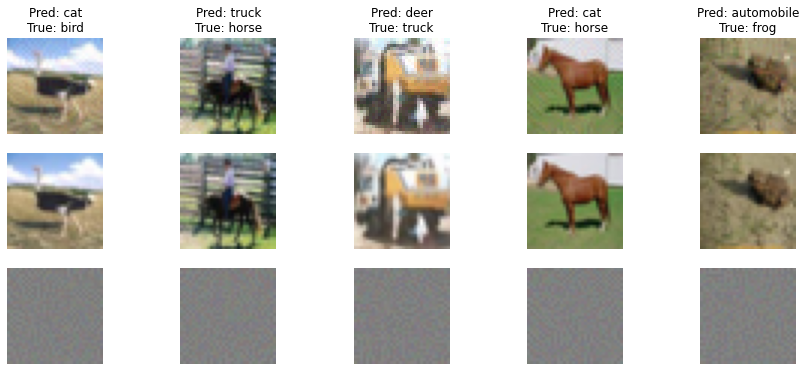

In [6]:
# 获取预测结果
output = model(adv_images.to(device))
_, adv_pred = torch.max(output, 1)  # 得到预测标签


# 绘制图像
fig, axes = plt.subplots(3, 5, figsize=(15, 6)) 


for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    adv_img = denorm(adv_images)[i].cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    img = denorm(images)[i].cpu().numpy().transpose((1, 2, 0))
    noise = denorm(eta)[i].detach().cpu().numpy().transpose((1, 2, 0))
    


    # 显示对抗样本
    axes[0, i].imshow(adv_img)
    axes[0, i].axis('off')
    predicted_label = classes[adv_pred[i]]
    true_label = classes[labels[i].item()]
    axes[0, i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}")
    
    # 显示原始图像
    axes[1, i].imshow(img)
    axes[1, i].axis('off')

    # 显示对抗噪声
    axes[2, i].imshow(noise)
    axes[2, i].axis('off')

plt.show()